# Multi-Layer Artificial Neural Networks

Full example is available on the [Multi-Layer ANN Example Python notebook by Sebastian Jaimungal](https://github.com/sebjai/STA2536/blob/master/ANN_Basics/Multi-Layer%20ANN%20Example.ipynb).

In [2]:
import numpy as np
from numpy import genfromtxt

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

## Define a class for the ANN structure

In [3]:
class MyNet(nn.Module):
    # constructor
    def __init__(self, nNodes, nLayers ):
        super(MyNet, self).__init__()
        
        # single input layer
        self.prop_in_to_h = nn.Linear( 1, nNodes)
        
        # nLayers hidden layers 
        self.prop_h_to_h = []
        for i in range(nLayers-1):
            self.prop_h_to_h.append(nn.Linear(nNodes, nNodes))
        
        # single output layer
        self.prop_h_to_out = nn.Linear(nNodes, 1)

    def forward(self, x):
        
        # input layer with sigmoid as activation function
        h = torch.sigmoid(self.prop_in_to_h(x))
        
        # hidden layers with ReLU as activation function
        for prop in self.prop_h_to_h:
            h = torch.relu(prop(h))
        
        # output layer with no activation
        y = self.prop_h_to_out(h)
        
        return y
    
    def parameters(self):
        
        params = list(self.prop_in_to_h.parameters())
        for prop in self.prop_h_to_h:
            params += list(prop.parameters())
            
        params += list(self.prop_h_to_out.parameters())
        
        return params

## Creation of a single ANN

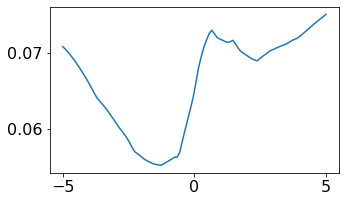

In [11]:
N_hidden = 100
N_layers = 3

Nets = MyNet(N_hidden, N_layers)

x = torch.tensor( np.expand_dims(np.linspace(-5,5,100), axis=1)).float()
y = Nets(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
plt.tight_layout(pad=5)
plt.show()

## Optimization of the ANN

Let's try to make the ANN fit the following function:
$$
\frac{1}{20} \left( \frac{5 \sin(x)}{1 + \exp(-x)} + x^2 - x - 5 \right).
$$

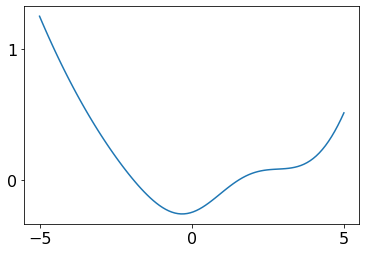

In [8]:
f = lambda x : ( 5*np.sin(x)/(1+np.exp(-x)) + x**2-x-5 ) /20
x = np.linspace(-5,5,100)

plt.plot(x,f(x))
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
plt.show()

In [9]:
def PlotFit(net):
    
    x = np.linspace(-5,5,100)
    plt.plot(x, f(x))
    xt = torch.tensor(np.expand_dims(x,axis=1)).float()
    plt.plot(x, net(xt).detach().numpy(), color='r' )


def FitNet(net, mini_batch_size, Nepochs):
    
    print(net)
    PlotFit(net)
    plt.show()
    
    # copy the net so we can compare SGD and Adam
    net_cp = copy.deepcopy(net)

    # create  optimizer
    optimizer = optim.SGD(net.parameters(), lr=0.005)
    optimizer_cp = optim.Adam(net_cp.parameters(), lr=0.005)

    loss_hist = []
    loss_hist_cp = []

    for epoch in range(Nepochs):  # loop over the dataset multiple times


        # grab a minibatch -- randomize over the range -5 to 5
        x = 10*np.random.rand(mini_batch_size,1)-5
        xt = torch.tensor(x, dtype=torch.float)  

        # the target function
        targets =  f(xt)

        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_cp.zero_grad()

        # push inputs forward through the whole net
        outputs = net(xt)
        outputs_cp = net_cp(xt)

        
        # compute the loss associated with this output
        loss = torch.mean((outputs-targets)**2)
        loss_cp = torch.mean((outputs_cp-targets)**2)

        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()
        loss_cp.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()
        optimizer_cp.step()

        # store running loss
        loss_hist.append(  loss.item() )
        loss_hist_cp.append(  loss_cp.item() )

        # plot output every 100 iterations
        if( ( (epoch) % 100 == 0) and (epoch>10) ):
            print(epoch)
            plt.figure(figsize=(10,8))
            
            plt.subplot(2,2,1)
            plt.title('SGD')
            plt.plot(loss_hist)
            plt.yscale('log')
            
            plt.subplot(2,2,2)
            PlotFit(net)
            
            plt.subplot(2,2,3)
            plt.title('ADAM')
            plt.plot(loss_hist_cp)
            plt.yscale('log')
            
            plt.subplot(2,2,4)
            PlotFit(net_cp)
            
            plt.tight_layout(pad=2)
            plt.show()

    print(epoch)
    plt.figure(figsize=(10,8))

    plt.subplot(2,2,1)
    plt.title('SGD')
    plt.plot(loss_hist)
    plt.yscale('log')

    plt.subplot(2,2,2)
    PlotFit(net)

    plt.subplot(2,2,3)
    plt.title('ADAM')
    plt.plot(loss_hist_cp)
    plt.yscale('log')

    plt.subplot(2,2,4)
    PlotFit(net_cp)

    plt.tight_layout(pad=2)
    plt.show()

    print('Finished Training')
    
    return loss_hist, net, net_cp

## Evolution of the ANN

With this function, we can see the progression of the optimization process for the ANN when using either the SGD or Adam optimizer. We observe that the Adam optimizer gives better results, more specifically it converges faster to the desired function.

MyNet(
  (prop_in_to_h): Linear(in_features=1, out_features=100, bias=True)
  (prop_h_to_out): Linear(in_features=100, out_features=1, bias=True)
)


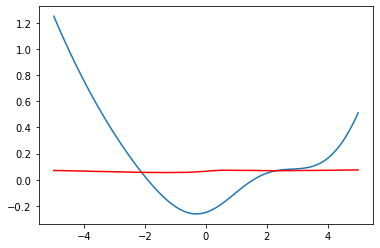

100


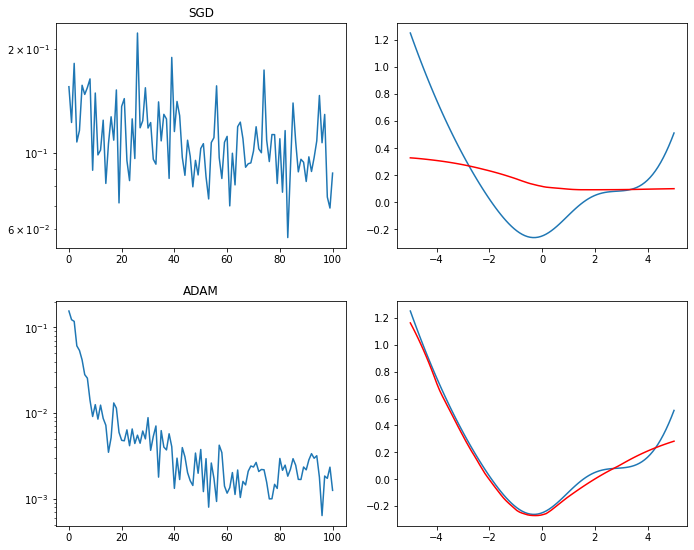

200


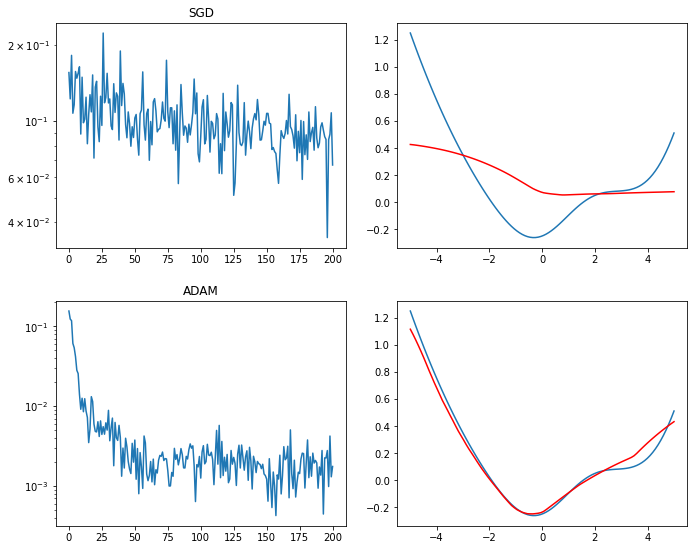

300


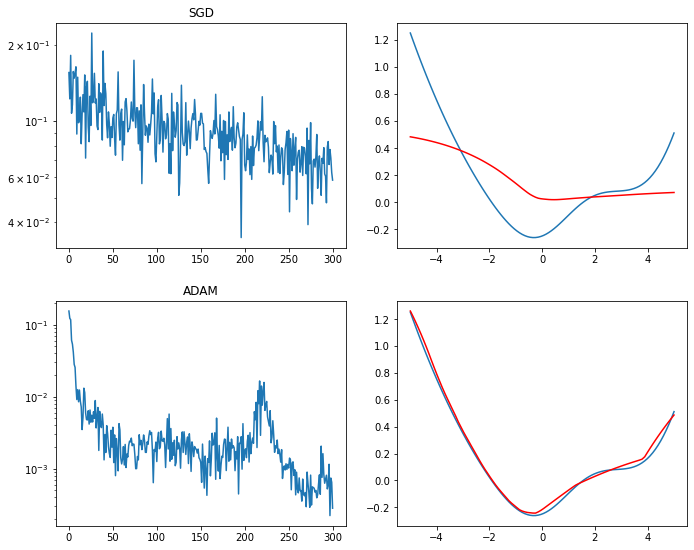

400


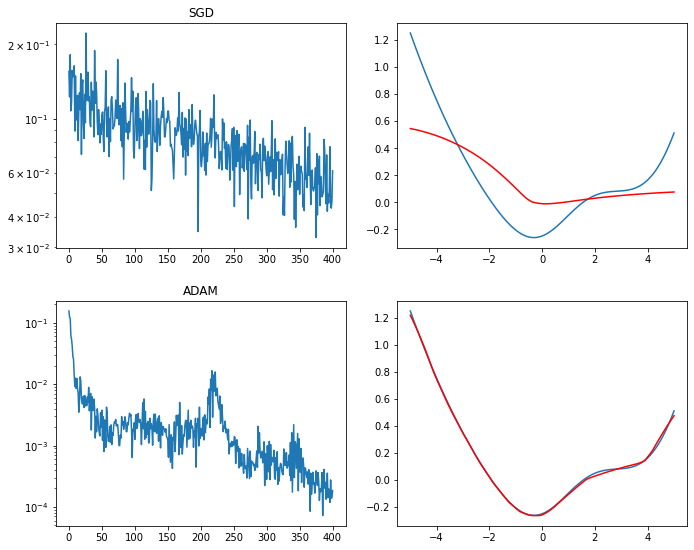

500


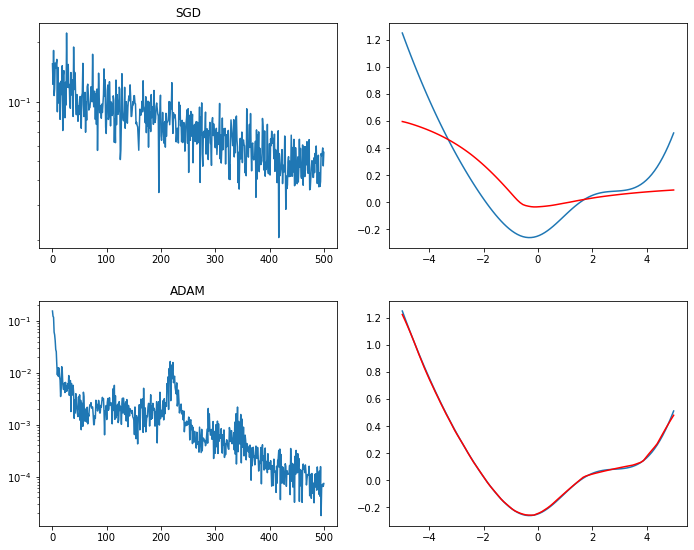

600


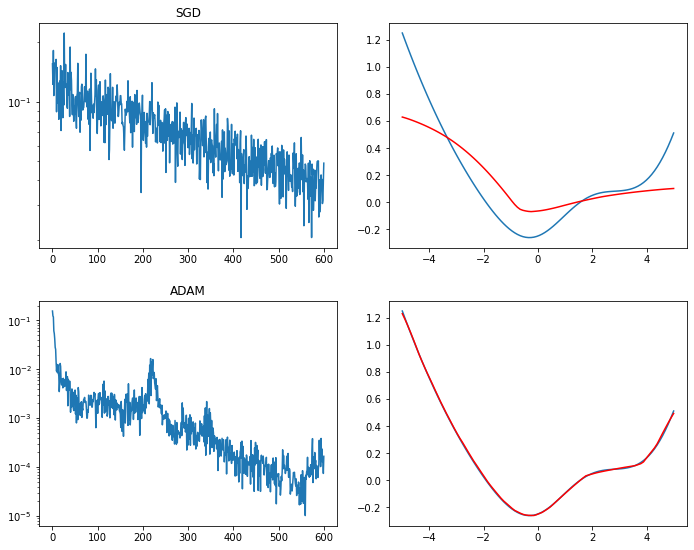

700


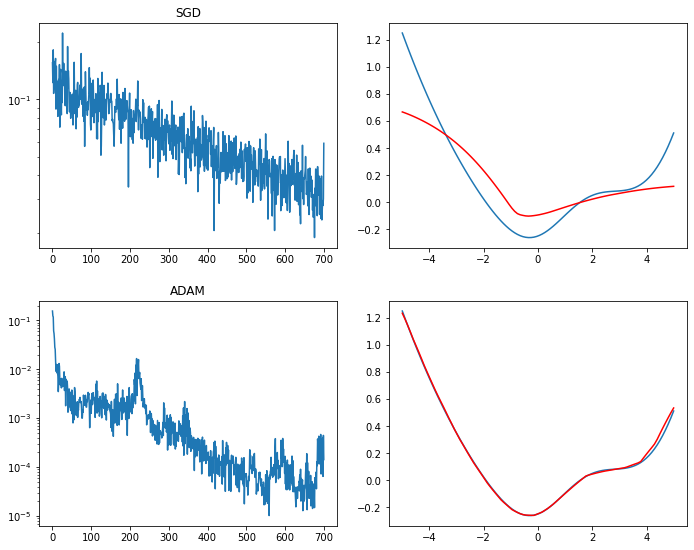

800


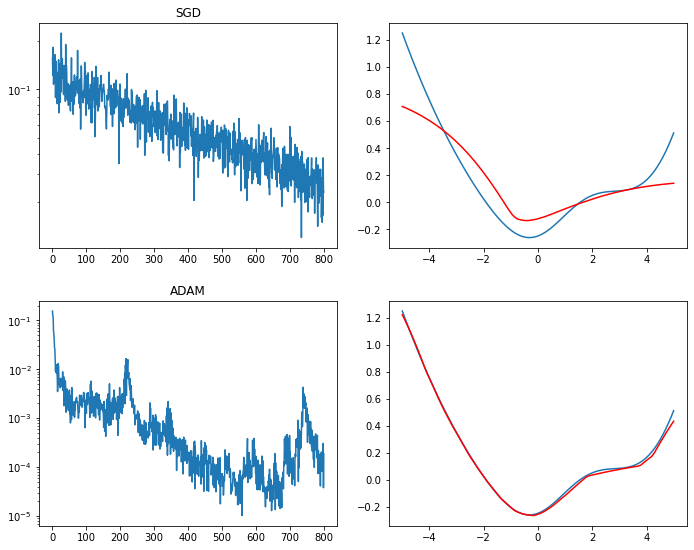

900


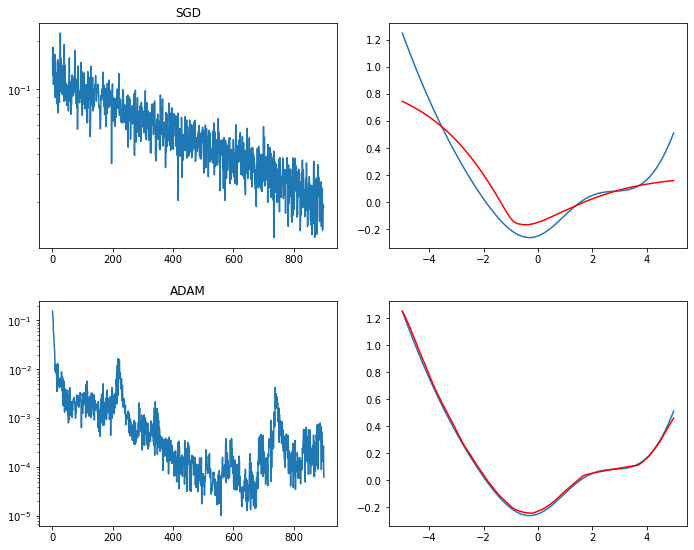

999


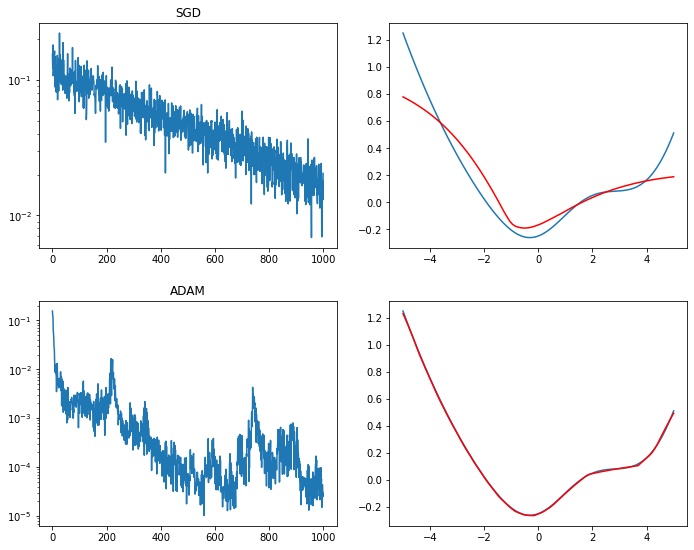

Finished Training


In [12]:
loss_hist, net, net_cp = FitNet(Nets, 50, 1000)